In [11]:
import numpy as np
import matplotlib.pyplot as plt
from math import expm1

In [12]:
def sas_3j1x_x(q):
    SPH_J1C_CUTOFF = 0.1
    if (np.fabs(q) < SPH_J1C_CUTOFF):
        q2 = q*q
        return (1.0 + q2*(-3./30. + q2*(3./840. + q2*(-3./45360.))))
    else:
        sin_q = np.sin(q)
        cos_q = np.cos(q)
        return 3.0*(sin_q/q - cos_q)/(q*q)

def sas_sinx_x(x):
    if np.isclose(x, 0.0):
        return 1.0
    else:
        return np.sin(x)/x

def get_contrasts(d):
    rho_solv = 1

    if d==1:
        # Homogenous
        rho_s = rho_solv+1
        rho_c = rho_solv+1
    if d==2:
        # Shell
        rho_s = rho_solv
        rho_c = rho_solv+1
    if d==3:
        # core
        rho_s = rho_solv+1
        rho_c = rho_solv

    return rho_solv, rho_s, rho_c

# Example (units in Å)
Vc = 4000
Vs = 4000
eps = 2
R = 40
Vs_total = (4/3)*np.pi*eps*(R**3)
N = 67
Rg = 10
d = 1.0
rho_solv, rho_s, rho_c = get_contrasts(2)
V_total = N*(Vs+Vc) 
ndensity = 8.94

params = {'v_core' : Vc,
         'v_corona' : Vs,
         'sld_solvent' : rho_solv,
         'sld_core' : rho_s,
         'sld_corona' : rho_c,
         'radius_core': R,
         'rg': Rg,
         'eps': eps,
         'd_penetration':d,
         'n_aggreg' : N,
         'v_total' : V_total 
         }

In [13]:
def r(R, eps, alpha):
    return R*(np.sin(alpha)**2 + (eps*np.cos(alpha))**2)**(0.5)

def orientational_average(f, num_alpha = 200):
    """ Compute orientational average

    f should be a function of alpha
    """
    alpha = np.linspace(0, np.pi, num=num_alpha)
    integrand = [f(a)*np.sin(a) for a in alpha]

    return np.trapz(integrand, x = alpha)

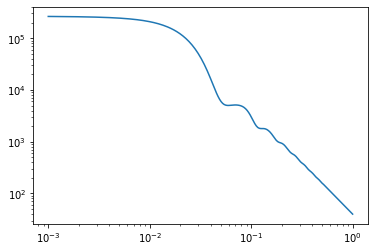

In [14]:
def micelle_elliposidal_kernel(q,
        v_core=None,
        v_corona=None,
        v_total=None,
        sld_solvent=None,
        sld_core=None,
        sld_corona=None,
        radius_core=None,
        rg=None,
        eps=None,
        d_penetration=None,
        n_aggreg=None):
    
    rho_solv = sld_solvent     # sld of solvent [1/A^2]
    rho_core = sld_core        # sld of core [1/A^2]
    rho_corona = sld_corona    # sld of corona [1/A^2]

    beta_core = v_core * (rho_core - rho_solv)
    beta_corona = v_corona * (rho_corona - rho_solv)

    # Self-correlation term of the core
    bes_core = lambda a : sas_3j1x_x(q*r(radius_core, eps, a))
    Fs = orientational_average(lambda a : bes_core(a)**2)
    term1 = np.power(n_aggreg*beta_core, 2)*Fs

    # Self-correlation term of the chains
    qrg2 = np.power(q*rg, 2)
    debye_chain = 1.0 if qrg2==0.0 else 2.0*(expm1(-qrg2)+qrg2)/(qrg2**2)
    term2 = n_aggreg * (beta_corona**2) * debye_chain

    # Interference cross-term between core and chains
    qrg = q*rg
    chain_ampl =  1.0 if qrg==0.0 else -expm1(-qrg)/qrg
    bes_corona = lambda a : sas_sinx_x(q*(r(radius_core, eps, a) + d_penetration * rg ))
    Ssc = chain_ampl*orientational_average(lambda a : bes_core(a)*bes_corona(a))
    term3 = 2.0 * (n_aggreg**2) * beta_core * beta_corona * Ssc

    # Interference cross-term between chains
    Scc = (chain_ampl**2)*orientational_average(lambda a : bes_corona(a)**2)
    term4 = n_aggreg * (n_aggreg - 1.0)* (beta_corona**2)*Scc

    # I(q)_micelle : Sum of 4 terms computed above
    i_micelle = term1 + term2 + term3 + term4

    # Normalize intensity by total volume
    return i_micelle/v_total

q = np.logspace(np.log10(1e-3), np.log10(1), 200)
Iq_micelle = np.asarray([micelle_elliposidal_kernel(qi, **params) for qi in q])
plt.loglog(q, Iq_micelle)
plt.show()

[homogenous] :  1 2 2
[shell] :  1 1 2
[core] :  1 2 1


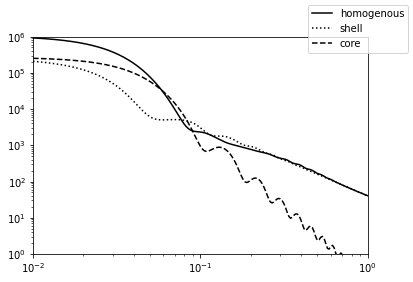

In [15]:
fig, ax = plt.subplots()
labels =['homogenous', 'shell', 'core']
linestyles = ['solid','dotted','dashed' ]
for i in range(3):
    rho_solv, rho_s, rho_c = get_contrasts(i+1)
    print('[%s] : '%labels[i], rho_solv, rho_s, rho_c)
    params = {'v_core' : Vc,    
            'v_corona' : Vs,
            'v_total' : V_total,
            'sld_solvent' : rho_solv,
            'sld_core' : rho_s,
            'sld_corona' : rho_c,
            'radius_core': R,
            'rg': Rg,
            'eps': eps,
            'd_penetration':d,
            'n_aggreg' : N,
            }
    q = np.logspace(np.log10(1e-2), np.log10(1), 200)
    Iq_micelle = np.asarray([micelle_elliposidal_kernel(qi, **params) for qi in q])
    ax.loglog(q, Iq_micelle, label=labels[i], ls=linestyles[i], color='k')
    ax.set_ylim([1e0, 1e6])
    ax.set_xlim([1e-2, 1e0])
fig.legend()
plt.show()